# Description
This will focus on using classic regression models and bayesian models. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [ ]:
! pip install vapeplot arviz pystan stan_utility

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    #normal try/except doesn't work on 'fatal' error
    except:
        ! git pull
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/src/analysis/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as common

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'ski-snow-modeling' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git pull

Already up to date.


In [ ]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
import pickle
import calendar
from typing import Union
from collections import namedtuple

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import vapeplot
import arviz as az

# modeling
import pystan
import stan_utility
from sklearn.metrics import r2_score

# project specific
from project_utils import project_utils as common

%load_ext autoreload
%autoreload 2

# Parameters

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))
iters = 200
chains = 4

# Load Data

In [ ]:
file_path = r'../../data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)
model_path = r'./stan_model.pkl'
result_path = r'../../data/processed/stan_results.pkl'

In [ ]:
# parquet opening is broken on colab
with open(file_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0

# Feature Engineering
refactored into project_utils module

### Split Data and sample dense areas

In [ ]:
# I want to oversample rare months, but will want to use the last year as the test set.
long_series_df.query('basecol_interpolated==False')[['ski_yr', 'pseudo_ts', 'snowfall']]\
.assign(month=lambda x: x.pseudo_ts.dt.month)\
.drop(columns=['pseudo_ts'])\
.pivot_table(index=['month'], columns=['ski_yr'], values='snowfall', aggfunc='count')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


ski_yr     0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0
month                                                                         
1       4735.0  6067.0  6227.0  6240.0  6331.0  5975.0  5989.0  5914.0  5840.0
2       4376.0  5545.0  5781.0  5716.0  5484.0  5650.0  5158.0  5277.0  4949.0
3       4491.0  4810.0  5852.0  5795.0  5017.0  4507.0  4608.0  5060.0  5043.0
4       1534.0  1596.0  1798.0  2009.0  1229.0  1318.0  1594.0  1646.0  1703.0
5        162.0   153.0   210.0   266.0    92.0   183.0   178.0   185.0   305.0
6         25.0    17.0    31.0    52.0    12.0    49.0    23.0    26.0   122.0
7          2.0     2.0     4.0    27.0     NaN     1.0    17.0    10.0    31.0
8          NaN     2.0     4.0     NaN     NaN     NaN     1.0     6.0     1.0
9          NaN     NaN     NaN     1.0     NaN     NaN     NaN     1.0     1.0
10         NaN    54.0    44.0    69.0    32.0    15.0    18.0    33.0    63.0
11       735.0  1056.0  1072.0  1060.0  1518.0   819.0   568.0   891.0   997.0
12      4299.0  4471.0  4247.0  5293.0  5237.0  3367.0  4572.0  3976.0  4356.0

In [ ]:
# set aside some data for multi-step analysis
leaveouts = ['Eldora', 'Seven Springs']
stan_multistep_test_df = (long_series_df.query('station in @leaveouts')
                         .pipe(common.add_month)
                         .pipe(common.add_diff, ar_terms=1)
                         .pipe(common.ohe, 'region')
                         .pipe(common.monthly_mixture)
                         .pipe(common.cleaner))

add_month: time=0:00:00.002130, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 13)
add_diff: time=0:00:00.013205, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 14)
ohe: time=0:00:00.006657, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 15)
monthly_mixture: time=0:00:00.030993, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 27)
cleaner: time=0:00:00.006318, type=<class 'pandas.core.frame.DataFrame'>, shape=(2409, 19)


In [ ]:
stan_train_df, stan_test_df = (long_series_df
           .drop(index=stan_multistep_test_df.index)
           .pipe(common.add_month)
           .pipe(common.add_diff, ar_terms=0)
           .pipe(common.ohe, 'region')
           .pipe(common.monthly_mixture)
           .pipe(common.cleaner)
           .pipe(common.train_test_split_ts, exog_cols='all', ski_yr_cutoff=7, as_monthly=False)
           )
stan_train_df = stan_train_df.pipe(common.sample_weighted_season)
train_data = common.subsets(stan_train_df)
test_data = common.subsets(stan_test_df)

stan_data_test = common.data_packager(train=train_data, test=test_data)

add_month: time=0:00:00.094564, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
add_diff: time=0:00:00.463679, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
ohe: time=0:00:00.114731, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 20)
monthly_mixture: time=0:00:00.539155, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 32)
cleaner: time=0:00:00.042133, type=<class 'pandas.core.frame.DataFrame'>, shape=(198030, 24)
sample_weighted_season: time=0:00:00.280214, type=<class 'pandas.core.frame.DataFrame'>, shape=(21816, 23)


# Bayesian Model in Stan (MCMC)
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.); changes at odds with this should be considered as noise. A bayesian model allows for this.

In [ ]:
functions_block = """// for function
"""
data_block_basic = """
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    """
data_block_test = """
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    """
data_block = data_block_basic + data_block_test

transformed_data_block = """
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_test = to_row_vector(X_snow_test);
    
    for (k in 1:K_reg) {          //  K_regxN * Nx1  T
        for (n in 1:N) {
            X_reg_snow[n,k] = X_snow_rvect[n] * X_reg[n,k];
    }  }
    
    // same, but for test. Should do this with a function...
    for (k in 1:K_reg) {
        for (n in 1:N_test) {
            X_reg_snow_test[n,k] = X_snow_rvect_test[n] * X_reg_test[n,k];
    } }"""
parameters_block = """
    // intercept was causing divergences and coef interpretation 
    // makes more sense without intercept: 
    // I don't expect change in base depth absent melting or snowfall
    vector<upper=0>[K_month] beta_mo;           // coefficients for melting
    vector<lower=0, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;                        // must be +ve
    real<lower=0> sig_mos;                      // must be +ve
    """
transformed_parameters_block = """ """
model_block_vars = """
    vector[N] mu;                       // y_hat
    """
model_block_sampling = """
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist"""
model_block_y = """
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
    """
model_block = model_block_vars + model_block_sampling + model_block_y
generated_quantities_block = """
    vector[N_test] y_test;
    for(n in 1:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow, sigma);
    }
    """
# assemble model
def create_stan_model(functions_block=functions_block, data_block=data_block, 
                      transformed_data_block=transformed_data_block, 
                      parameters_block=parameters_block, 
                      transformed_parameters_block=transformed_parameters_block, model_block=model_block,
                      generated_quantities_block=generated_quantities_block):
    return f'''
    functions {{{functions_block}}}
    data {{{data_block}}}
    transformed data {{{transformed_data_block}}}
    parameters {{{parameters_block}}}
    transformed parameters {{{transformed_parameters_block}}}
    model {{{model_block}}}
    generated quantities {{{generated_quantities_block}}}'''

stan_model_str = create_stan_model(generated_quantities_block=" ")

In [12]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')
print(stan_model_str)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_e41f59a6f9a3d55a4f7a35c7ba50e2b5 NOW.



    functions {// for function
}
    data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    }
    transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_te

In [13]:
# avoid recompile if possible
with open(model_path, 'wb') as f:
    pickle.dump(sm, f)

In [14]:
fit = sm.sampling(data=stan_data_test, iter=iters, chains=chains, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

In [15]:
# for overnight run
try:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)
# reload saved objects if not reruning sampler
except NameError:
    with open(model_path, 'rb') as f:
        sm = pickle.load(f)
    with open(result_path, 'rb') as f:
        fit = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. No Divergences! fix by reparameterization to avoid 'funnel' spots, or increasing adapt_delta, which causes smaller step size by requiring higher probability of step acceptance.

_



In [16]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


## Visualization of results

In [17]:
def plot_traces(fit_obj):
    """create traceplot of parameters"""
    fit_az = az.from_pystan(posterior=fit_obj,
                            dims={'beta_reg_snow': ['Coefficients_for_Snow_by_Region'],
                                'beta_mo': ['Melting_Coefficients_by_Month']},
                            coords={'Coefficients_for_Snow_by_Region': train_data.X_region.columns.values.tolist(),
                                    'Melting_Coefficients_by_Month': [calendar.month_name[i+1] for i in range(12)]}
                            )
    rc = {'plot.max_subplots': None}
    az.rcParams.update(rc)
    sns.set_style('whitegrid')
    az.plot_trace(fit_az);

In [18]:
# fix brackets in col nmaes
def get_fit_df(fit_obj):
    return (fit_obj.to_dataframe()
           .rename(columns=lambda x: x.replace("[", "_"))
           .rename(columns=lambda x: x.replace("]", "")))

In [19]:
def get_region_betas_df(fit_df:pd.DataFrame=None) -> pd.DataFrame:
    """get region names without 'region_' """
    region_names = [reg[7:] for reg in train_data.X_region.columns.values.tolist()]
    df = fit_df.filter(regex="reg", axis=1)
    reg_cols = df.columns
    df = (df
            .rename(columns={col: reg_name for col, reg_name 
                             in zip(reg_cols, region_names)})
            .melt(var_name="region"))
    # TODO: add in ar column??
    return df

def plot_snowfall_betas(region_betas_df:pd.DataFrame=None) -> None:
    """plots effect of snowfall on basedepth"""
    plt.style.use('bmh')
    fig = sns.kdeplot(x=region_betas_df.value, hue=region_betas_df.region, fill=True, cut=0, bw_adjust=.3)
    plt.suptitle("Estimated Base Increase per Unit of Snowfall", fontsize=20)
    plt.xlabel("Effect of Unit of Powder");

def plot_beta_estimates_region(region_beta_df:pd.DataFrame=None) -> None:
    plt.style.use('ggplot')
    jazzcup = sns.blend_palette(vapeplot.palette("jazzcup"), n_colors=region_betas_df.region.unique().size)
    f, ax = plt.subplots(figsize=(12, 8))
    sort_order = region_betas_df.groupby(['region']).mean().sort_values(by='value', ascending=True).index

    sns.violinplot(x='region', y='value', data=region_betas_df,
                order=sort_order, palette=jazzcup)

    plt.title("Estimated Base Increase per Unit of Snowfall: Bayesian Model", fontsize=20)
    plt.xlabel('Region')
    plt.ylabel('Fraction of Full Unit of Powder');

In [20]:
def get_month_betas(fit_df: pd.DataFrame=None) -> pd.DataFrame:
    """extract month betas from fit object"""
    dataf = fit_df.filter(like='beta_mo').melt(var_name="month")
    dataf = dataf[dataf.value > dataf.value.quantile(.02)]
    month_map = {f"beta_mo_{i}": calendar.month_abbr[i] for i in range(1, 13)}
    dataf['month'] = dataf['month'].replace(month_map).astype('str')
    return dataf

In [21]:
def plot_snow_betas(df: pd.DataFrame=None, start_mo: str='Jan')->None:
    """plots estimates of daily snow melta by month"""
    fig, ax = plt.subplots()
    month_ordered = [mo for mo in calendar.month_abbr[1:] if mo in df.month.unique()]
    start_mo_ix = month_ordered.index(start_mo)
    month_ordered = month_ordered[start_mo_ix:] + month_ordered[:start_mo_ix]
    sns.boxplot(data=df, y='value', x='month', order=month_ordered,
                ax=ax, )
    ax.set_ylabel('Inches Melted per Day')
    ax.set_xlabel('Month')
    ax.set_title('Estimated Snow Melted per Day by Month');

In [22]:
fit_df = get_fit_df(fit)
fit_df.head()

chain  draw  warmup  ...  n_leapfrog__  divergent__      energy__
0      0     0       0  ...            15            0  32187.099701
1      0     1       0  ...            15            0  32183.758026
2      0     2       0  ...            15            0  32181.763983
3      0     3       0  ...            15            0  32188.588284
4      0     4       0  ...            15            0  32191.033656

[5 rows x 32 columns]

In [23]:
month_betas_df = get_month_betas(fit_df)
month_betas_df.head()

month     value
0   Jan -0.002010
1   Jan -0.001588
2   Jan -0.011206
3   Jan -0.000662
4   Jan -0.000979

In [24]:
region_betas_df = get_region_betas_df(fit_df=fit_df)
region_betas_df.head(2)

region     value
0  Cascades  0.085646
1  Cascades  0.053381

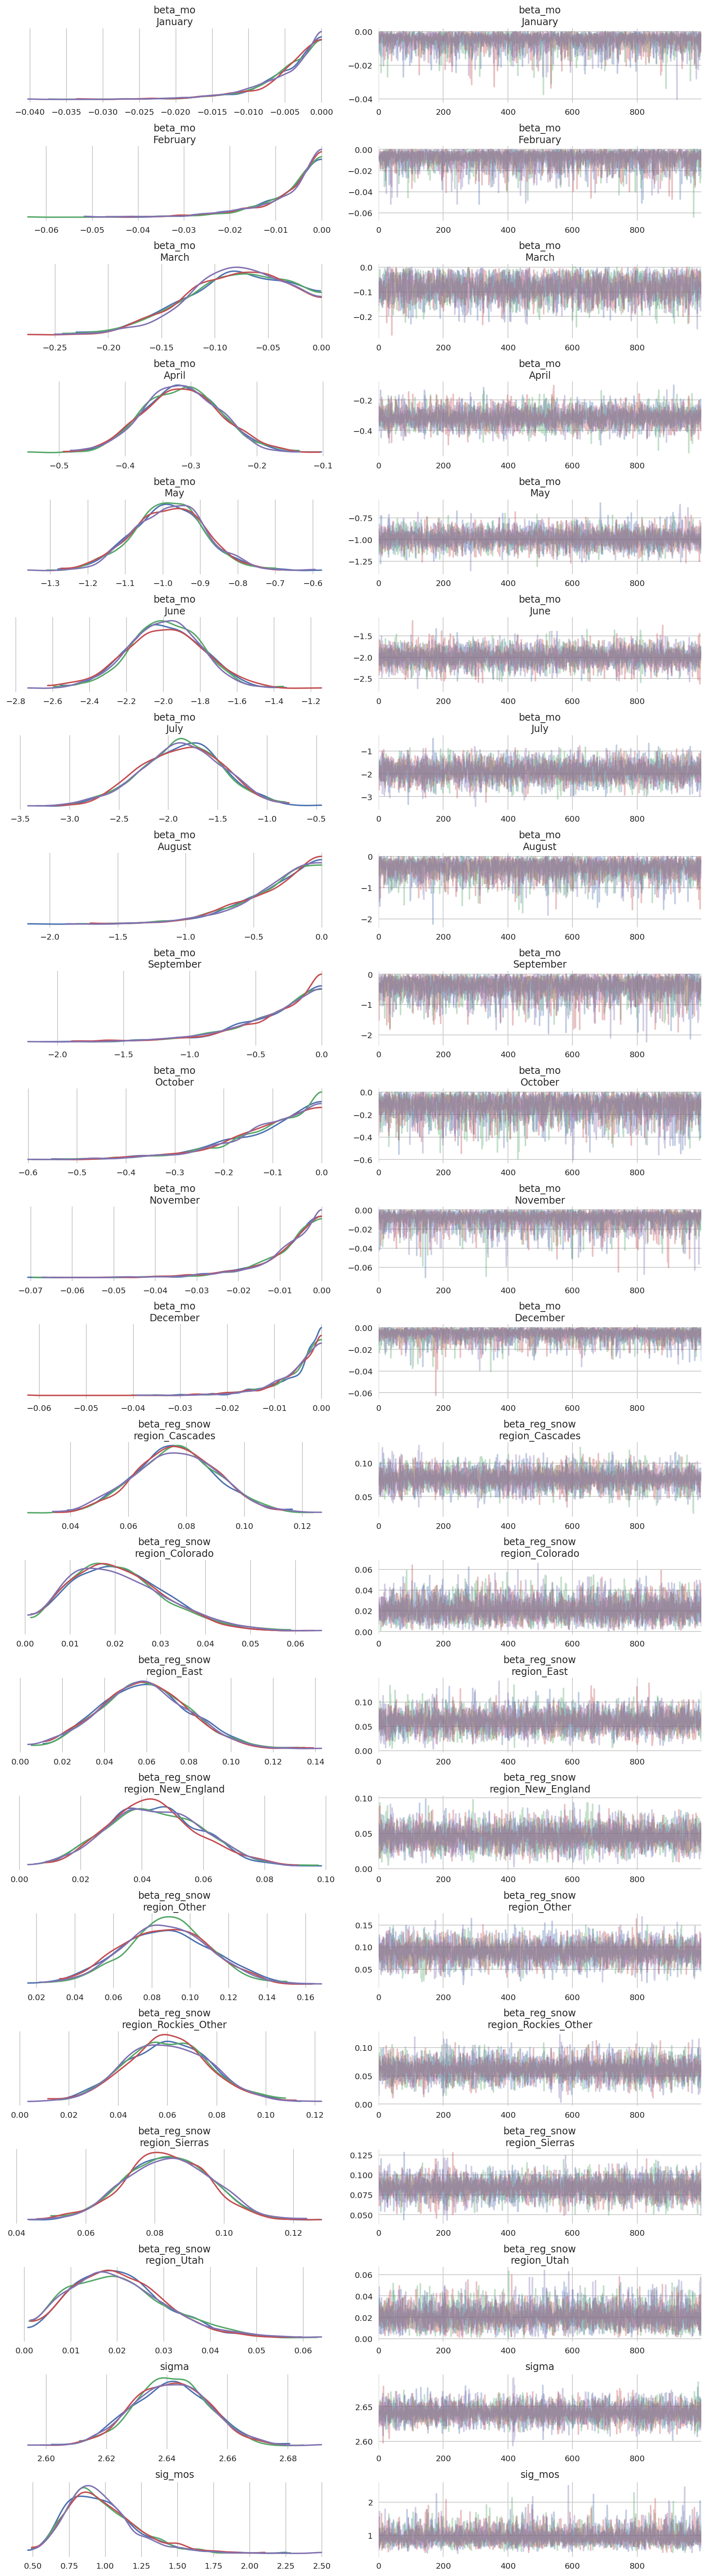

In [25]:
plot_traces(fit)

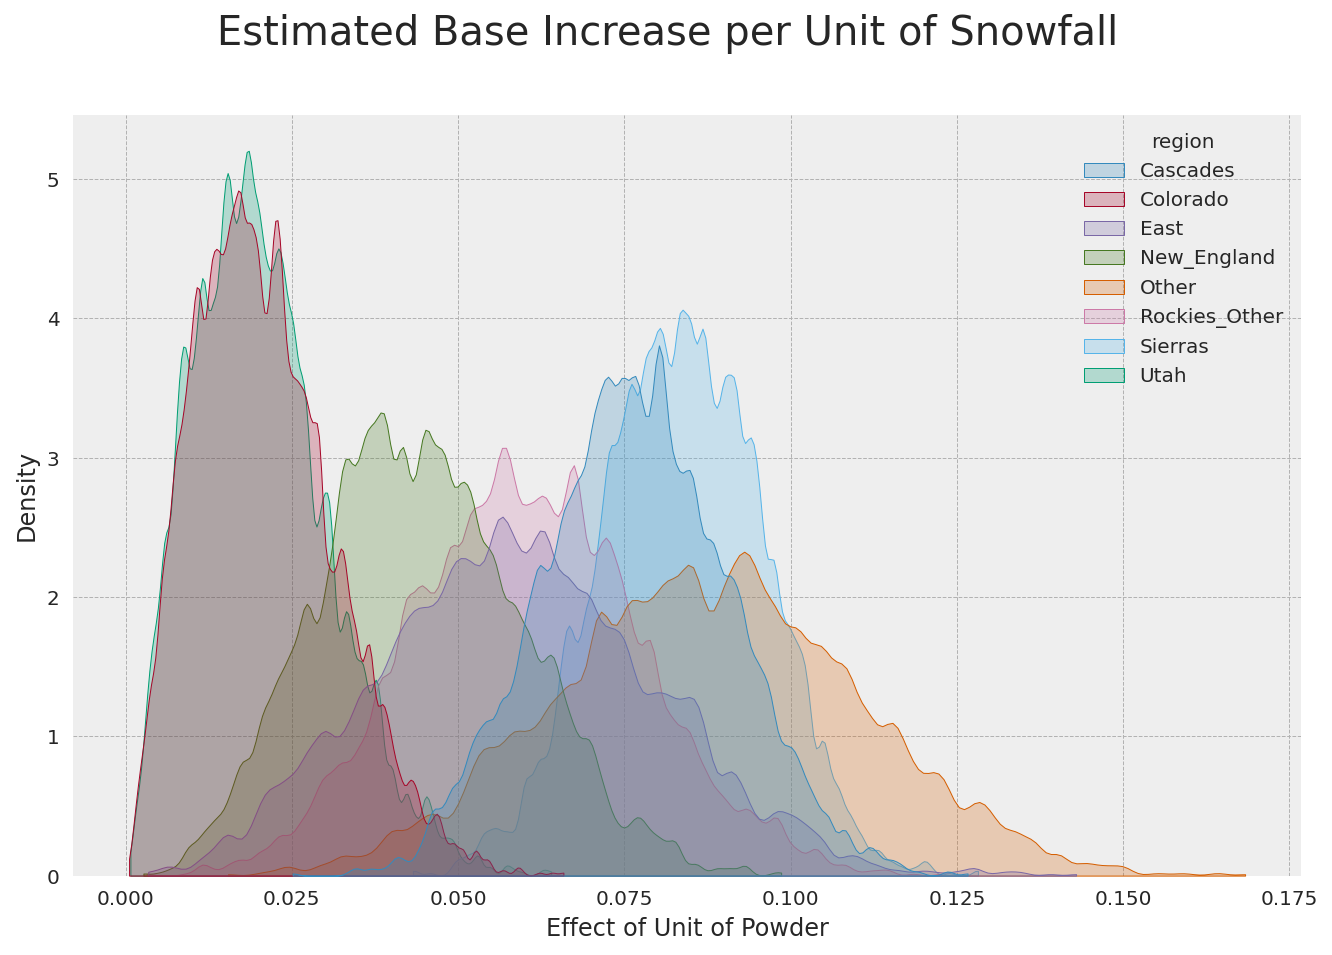

In [26]:
plot_snowfall_betas(region_betas_df)

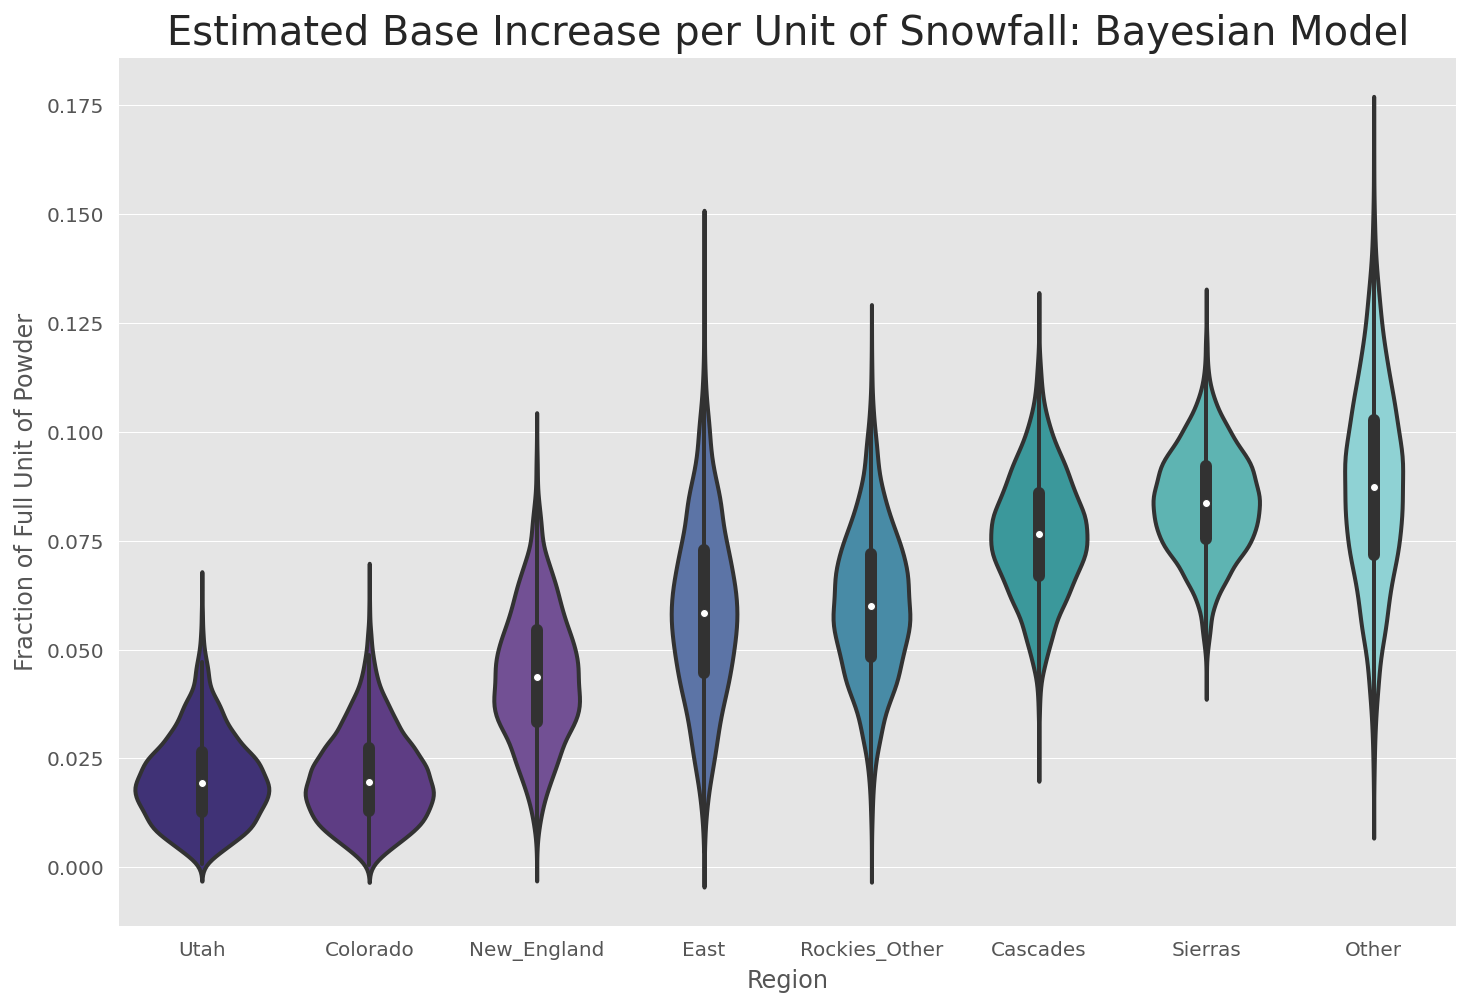

In [27]:
plot_beta_estimates_region(region_betas_df)

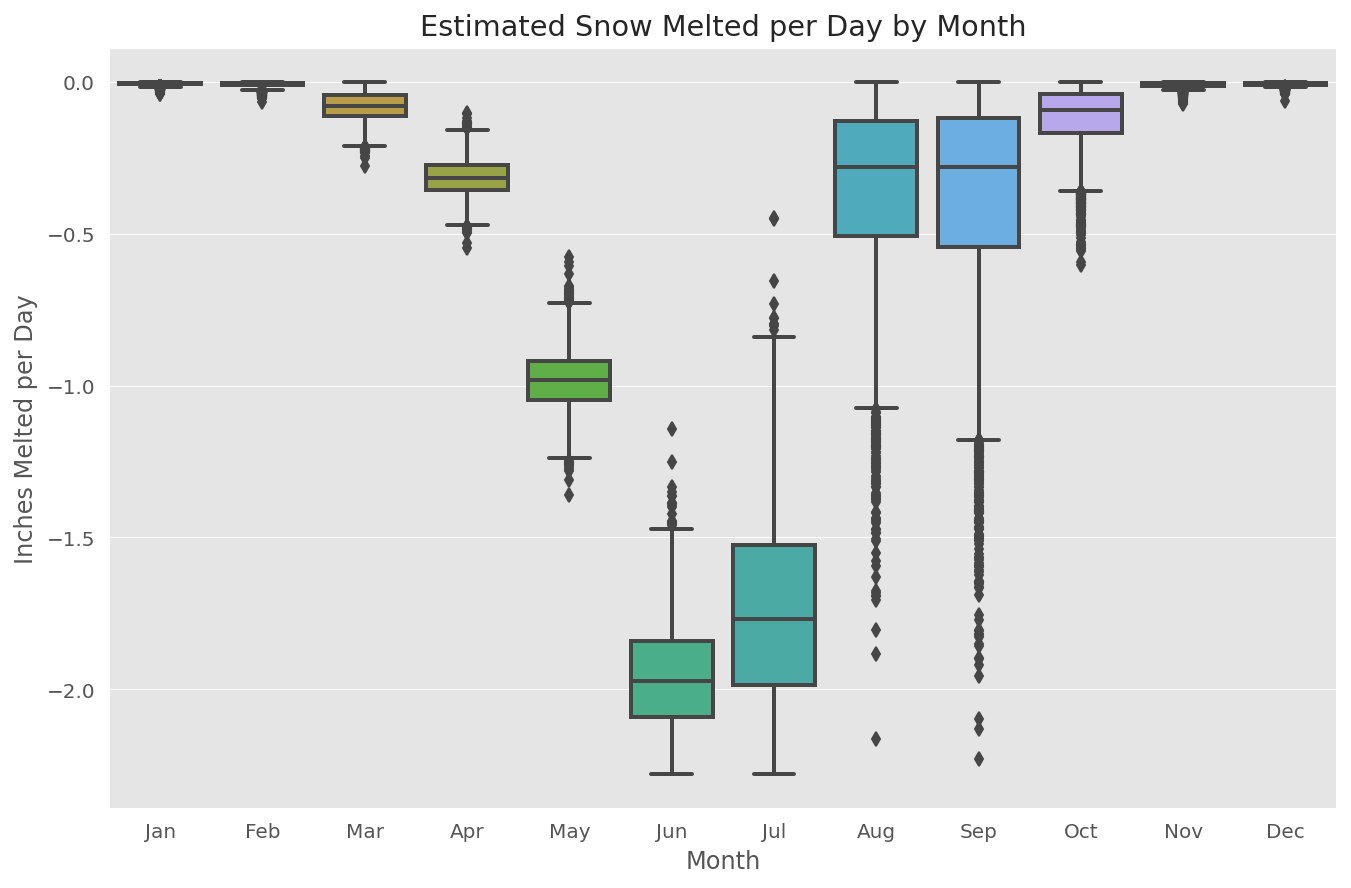

In [28]:
plot_snow_betas(month_betas_df, "Jan")

These estimates are mostly expected, but there seems to be low melting amounts during summer...this can be explained when we realize that most of the values for July-Sept are from the handful of resorts with glacier skiing. The averages aren't weighted by ski acreage, so the large number of small ski stations on the east coast & midwest with short seasons are disproportionately affecting these numbers. We could extend the model by breakin out melting to just the interaction of month x region.

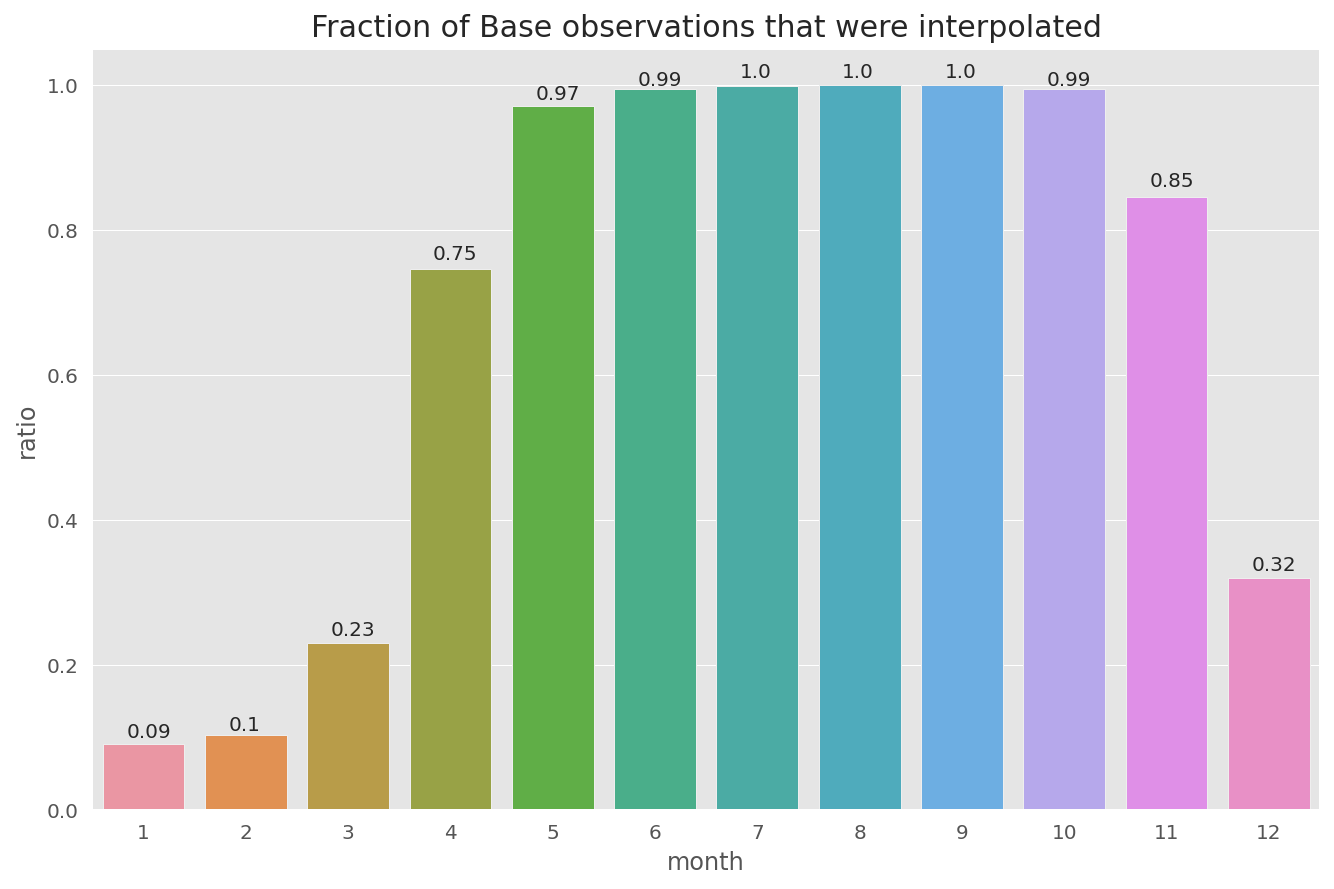

In [29]:
interpo_ratios=(long_series_df
    .assign(month=lambda x: x.pseudo_ts.dt.month)
    .groupby('month')
    .apply(lambda x: x.basecol_interpolated.sum()/x.shape[0])
    .to_frame()
    .reset_index()
    .rename(columns={0:'ratio'})
)
fig, ax = plt.subplots()
sns.barplot(data=interpo_ratios, x='month', y='ratio', ax=ax)
plt.title('Fraction of Base observations that were interpolated', fontsize=15)
[plt.text((i-.17), value+.01, str(value)) for i, value in enumerate(interpo_ratios.ratio.round(2).to_numpy())];

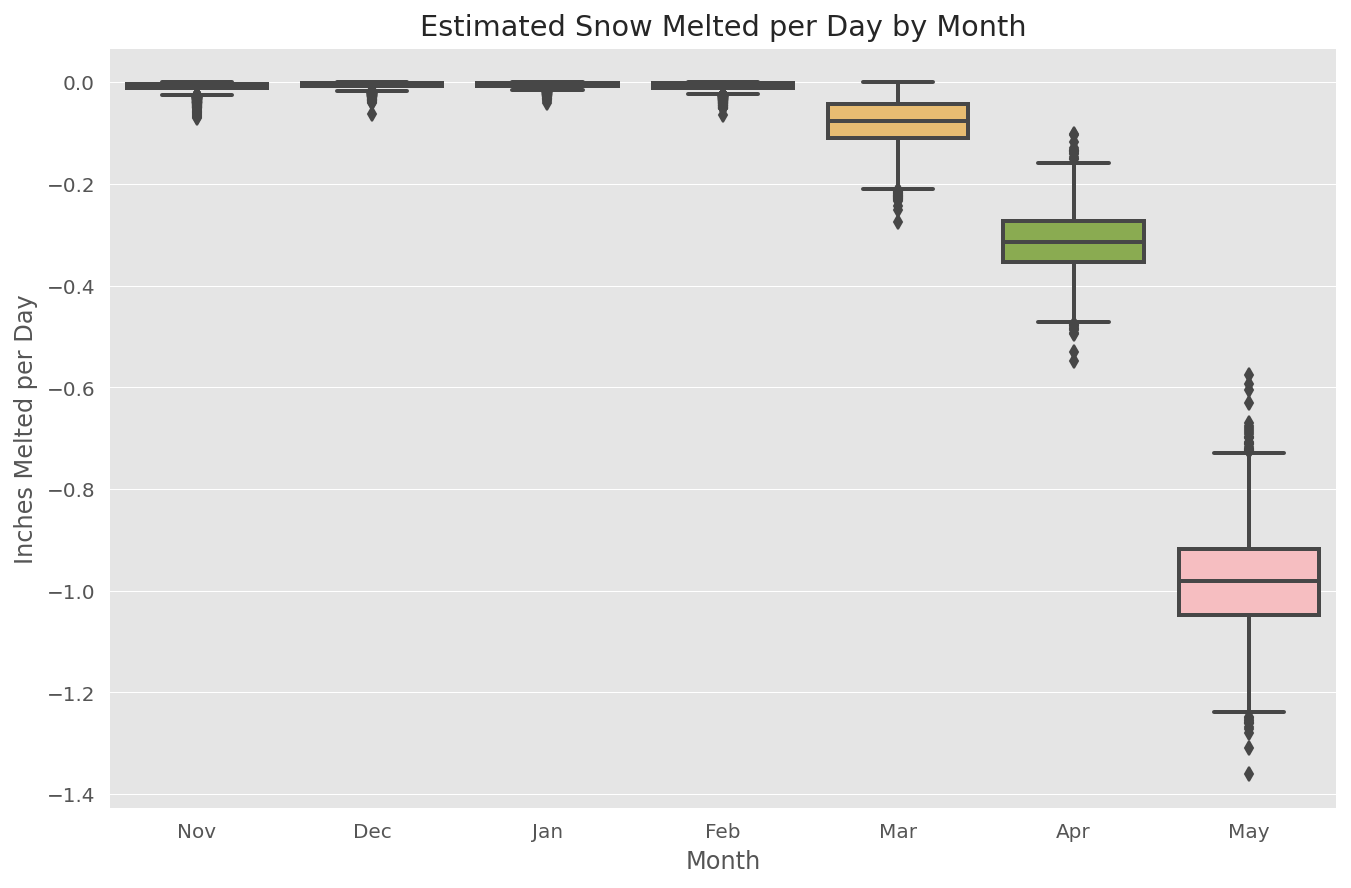

In [30]:
plot_snow_betas(month_betas_df[~month_betas_df.month.isin(['Jun', 'Jul', 'Aug', 'Sep', 'Oct'])], "Nov")

### Check test set metrics

In [31]:
def model_score(fit_object=None, input_data=stan_test_df) -> None:
    y_pred = pd.DataFrame(data=fit_object.extract(['y_test'], inc_warmup=False)['y_test'].T.mean(axis=1),
                      columns=['y_pred'])
    y_true = stan_test_df[['pseudo_ts', 'delta_base']]
    y_true.index = pd.to_datetime(y_true.index)
    print(f"R2 score for model: {r2_score(y_true=y_true.delta_base, y_pred=y_pred)}")
    y_pred_w_old = (pd.concat([y_pred.reset_index(drop=True),
                              y_true.reset_index(drop=True)],
                              axis=1, ignore_index=True)
                    .rename(columns={0:'y_pred', 1: 'pseudo_ts', 2: 'y_true'})
                    .set_index('pseudo_ts'))
    y_monthly = y_pred_w_old.resample('M').mean().dropna()    
    print(f"R2 score aggregated by month: {r2_score(y_true=y_monthly.y_true, y_pred=y_monthly.y_pred)}") 


In [32]:
stan_model_wtest_str = create_stan_model()
sm_wtest = pystan.StanModel(model_code=stan_model_wtest_str, model_name='stan_model_wtest')
fit_wtest = sm_wtest.sampling(data=stan_data_test, iter=iters, chains=chains, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)
model_score(fit_wtest)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_wtest_421e1b44f9056e92ce39d134b1866e9b NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


R2 score for model: 0.006265872272154471
R2 score aggregated by month: 0.2768082156897381


# Stan model including ARMA terms
I will not be using a seasonal model, since I think using months as predictors is more useful to capture seasonal changes in an interpretable way. However, I do want to caputure ARMA terms to improve model performance.

Because I am also calculating change in the base, this is a version of a (1,1,0) ARIMA model.

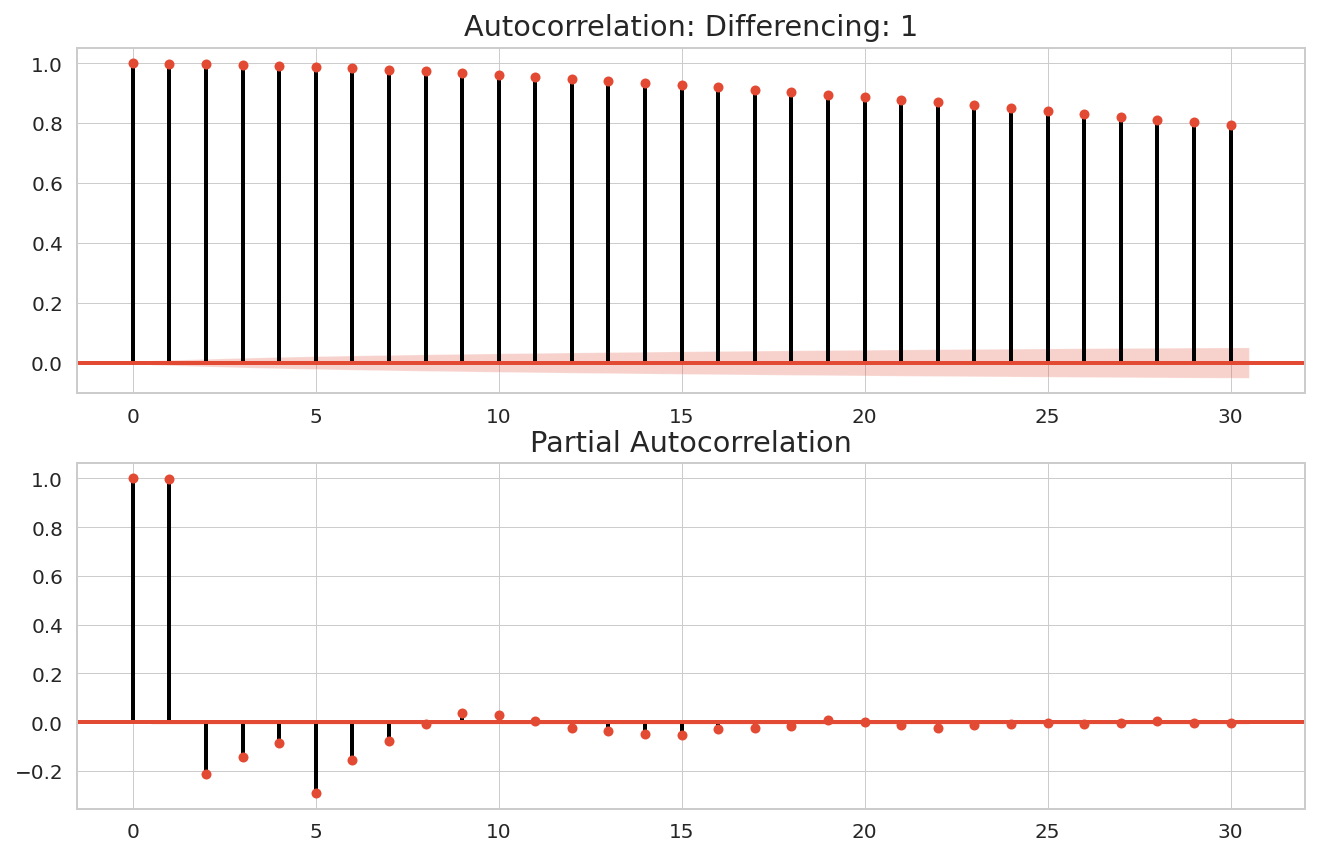

In [33]:
plt.rc('figure', figsize=(11.0, 7.0))
sns.set_style('whitegrid')
common.AC_PAC_plotter(df=long_series_df.query('ski_yr==1')[['base']], differences=1)

There is a long decay in the ACF, and a single (not including the 0 lag) positive PACF correlation. This is a classic AR(1) signature, so I will add that to the model. Adding another differencing term might be even better, but then all of the coefficients would lose the usefulness of their interpretability.

One way to at an AR relationship to the model would be with a line in the model:

`y[2:N] ~ normal(mu + y[1:(N - 1)]*beta_ar, sigma);`

but another is to add the lagged term as a feature and regress on it directly. (this wouldn't work for a MA term). This is useful because I can still sample from the data which helps with the dataset size.

In [34]:
# prepare data with AR feature
stan_train_ar_df, stan_test_ar_df = (long_series_df
           .drop(index=stan_multistep_test_df.index)
           .pipe(common.add_month)
           .pipe(common.add_diff, ar_terms=1)
           .pipe(common.ohe, 'region')
           .pipe(common.monthly_mixture)
           .pipe(common.cleaner)
           .pipe(common.train_test_split_ts, exog_cols='all', ski_yr_cutoff=7, as_monthly=False)
           )
stan_train_ar_df = stan_train_ar_df.pipe(common.sample_weighted_season)
train_ar_data = common.subsets(stan_train_ar_df)
test_ar_data = common.subsets(stan_test_ar_df)

stan_data_ar_w_test = common.data_packager(train=train_ar_data, test=test_ar_data)

add_month: time=0:00:00.088728, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
add_diff: time=0:00:00.482607, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 14)
ohe: time=0:00:00.140424, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 21)
monthly_mixture: time=0:00:00.557457, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 33)
cleaner: time=0:00:00.047467, type=<class 'pandas.core.frame.DataFrame'>, shape=(198030, 25)
sample_weighted_season: time=0:00:00.290490, type=<class 'pandas.core.frame.DataFrame'>, shape=(21816, 24)


In [35]:
print(model_block_vars + model_block_sampling + model_block_y)


    vector[N] mu;                       // y_hat
    
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
    


In [36]:
data_block_ar = data_block_basic + """
    matrix[N, 1] X_ar;   // autoregressive predictor features""" + data_block_test + """
    matrix[N_test, 1] X_ar_test;"""

parameters_block_ar = """
    vector<upper=0>[K_month] beta_mo;           // coefficients for melting
    vector<lower=0, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;                        // must be +ve
    vector<lower=0>[K_month] sig_mos;           // must be +ve
    real beta_ar;           // coefficients for prior days change in base
    """

model_block_ar = """
    vector [N] mu;
    sigma ~ cauchy(1, 10);
    sig_mos ~ cauchy(0, 20);
    sig_ar ~ cauchy(1, 10);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos[n]) T[,0];
    }
    beta_reg_snow ~ beta(2.2, 3);
    beta_ar ~ normal(0, sig_ar);
    for (n in 1:N) {
        mu[n] = X_month[n]*beta_mo + X_reg_snow[n]*beta_reg_snow + sum(X_ar[n]*beta_ar);
    }
    y ~ normal(mu, sigma);
    """

generated_quantities_ar = """
    vector[N_test] y_test;
    for(n in 1:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow + sum(X_ar_test[n]*beta_ar), sigma);
    }
"""

In [37]:
stan_model_ar_str = create_stan_model(data_block=data_block_ar, parameters_block=parameters_block_ar,
                                      model_block=model_block_ar, generated_quantities_block=generated_quantities_ar)
print(stan_model_ar_str)


    functions {// for function
}
    data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    matrix[N, 1] X_ar;   // autoregressive predictor features
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    
    matrix[N_test, 1] X_ar_test;}
    transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_ve

In [38]:
sm_ar = pystan.StanModel(model_code=stan_model_ar_str, model_name='stan_model_ar')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_ar_d64a81b44597706f6c53c3349c14fd05 NOW.


In [39]:
fit_ar = sm_ar.sampling(data=stan_data_ar_w_test, iter=iters, chains=chains, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples_ar",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [40]:
stan_utility.check_all_diagnostics(fit_ar)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [41]:
model_score(fit_object=fit_ar, stan_test_ar_df)

R2 score for model: 0.006935103314256841
R2 score aggregated by month: 0.30491868363063623


In [42]:
fit_ar_df = get_fit_df(fit_ar)
result_ar_df = get_region_betas_df(fit_ar_df)
fit_ar_df.head()

chain  draw  warmup  ...  n_leapfrog__  divergent__      energy__
0      0     0       0  ...            15            0  32453.051741
1      0     1       0  ...            15            0  32452.105946
2      0     2       0  ...            15            0  32449.444938
3      0     3       0  ...            15            0  32447.241955
4      0     4       0  ...            15            0  32462.774077

[5 rows x 21825 columns]

In [43]:
plot_traces(fit_ar)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f79366459d8> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 864x3.14136e+06 with 3546 Axes>

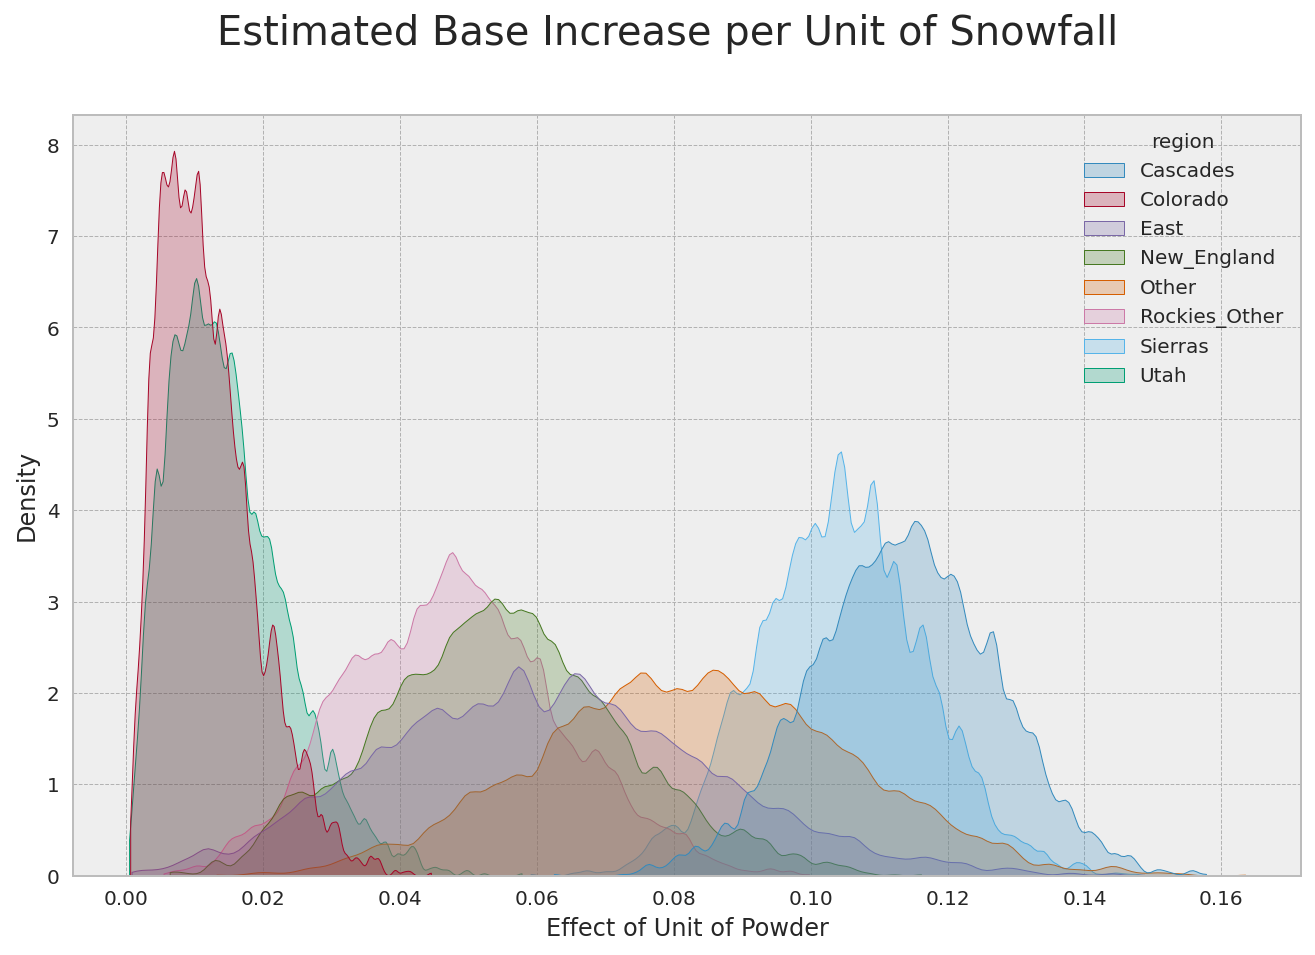

In [44]:
plot_snowfall_betas(result_ar_df)

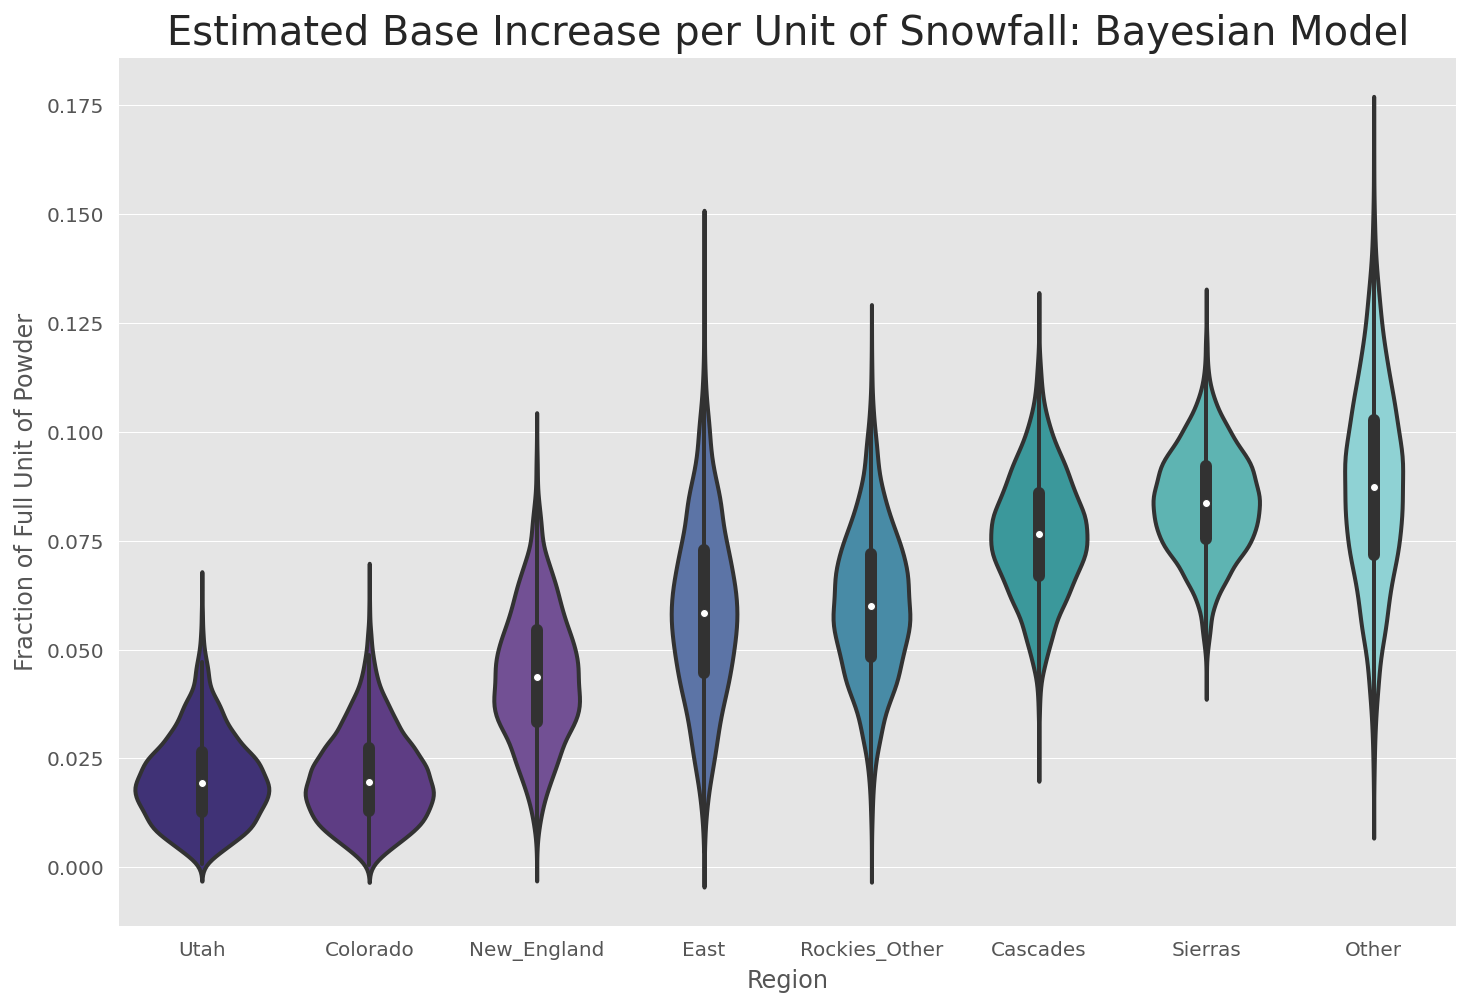

In [45]:
plot_beta_estimates_region(result_ar_df)

AttributeError: ignored

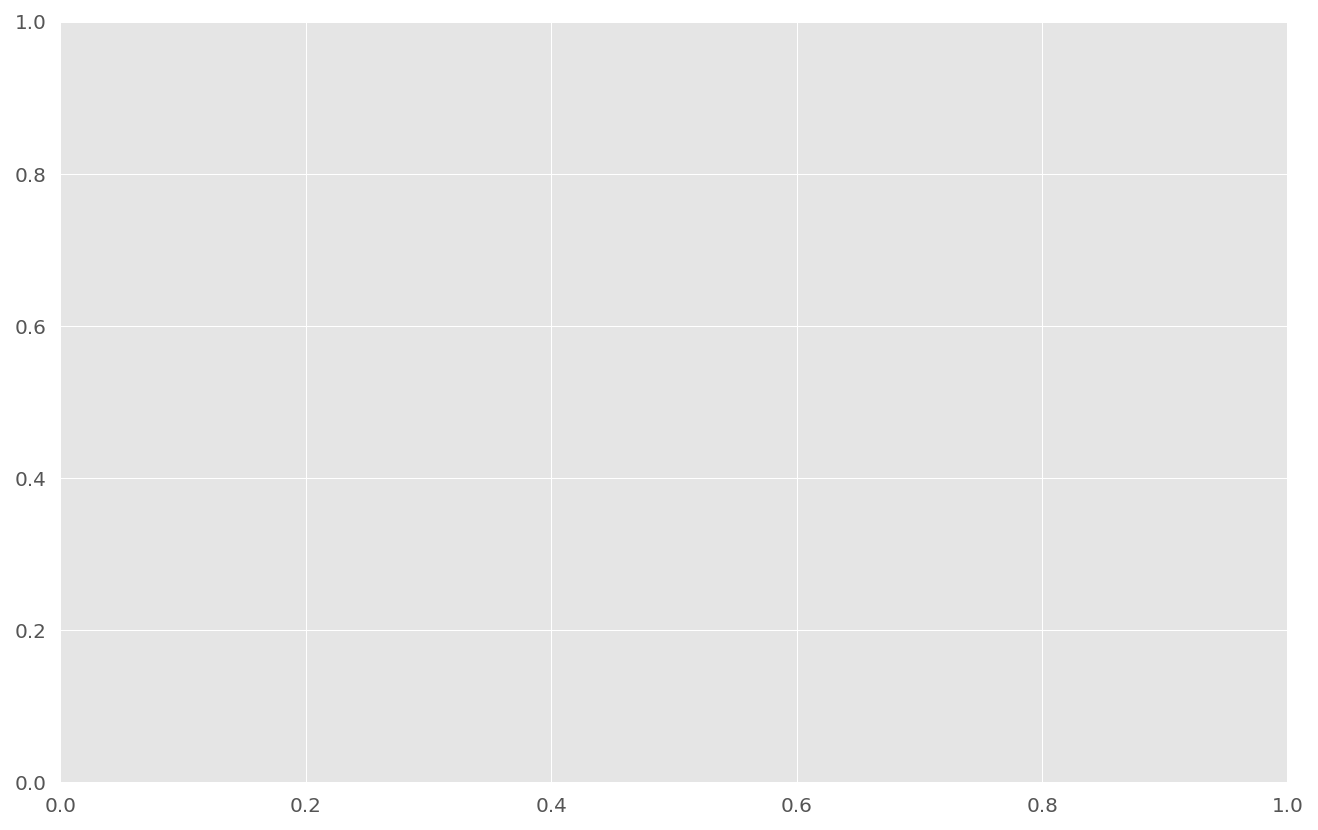

In [46]:
plot_snow_betas(result_ar_df)

In [50]:
fit_ar_df.beta_ar.describe()

count    4000.000000
mean        0.012060
std         0.007058
min        -0.013087
25%         0.007242
50%         0.011993
75%         0.016856
max         0.034181
Name: beta_ar, dtype: float64

#### Save results

In [ ]:
fit_ar_df \
[[c for c in fit_ar_df.columns if any(c.startswith("beta"), c.startswith("sig"))]] \
.describe() \
.T \
.to_parquet(path="../../data/processed/stan_betas.parquet")